In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 75.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [2]:
!pip install rtpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.1.1-py3-none-any.whl size=26666 sha256=2a439f36a25667b9bf040593e6bb63a1c2ac932a8766f905bb17cf9140f1a9d8
  Stored in directory: /root/.cache/pip/wheels/c9/2b/d9/a0b77d6e8623ce6b5c73813af455a3ace394abfc2e8aef7ed6
Successfully built gpustat


In [1]:
!git clone https://github.com/ChristophReich1996/ECG_Classification.git

Cloning into 'ECG_Classification'...
remote: Enumerating objects: 1999, done.
remote: Counting objects: 100% (1991/1991), done.
remote: Compressing objects: 100% (780/780), done.
remote: Total 1999 (delta 1226), reused 1934 (delta 1175), pack-reused 8 (from 1)
Receiving objects: 100% (1999/1999), 549.35 MiB | 23.49 MiB/s, done.
Resolving deltas: 100% (1226/1226), done.
Updating files: 100% (196/196), done.


In [2]:
%cd ECG_Classification

/content/ECG_Classification


In [4]:
import zipfile
import os

# Path to the uploaded zip file
zip_path = "/content/mit-bih-atrial-fibrillation-database-1.0.0.zip"

# Unzip to a folder named 'data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data")

In [8]:
import os
import wfdb
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy.signal import resample
import torch.nn.functional as F
from torchaudio.transforms import Spectrogram
from collections import Counter

FS_SRC = 250
FS_TGT = 300
SEGMENT_SECONDS = 30
SAMPLES_PER_SEGMENT = FS_TGT * SEGMENT_SECONDS

WINDOW_SIZE = 256
STEP_SIZE = 224
SPECTROGRAM_LENGTH = 563

class AFDBDualInputDataset(Dataset):
    def __init__(self, record_names, afdb_path):
        self.samples = []
        self.spectrogram_module = Spectrogram(n_fft=64, win_length=64, hop_length=32, power=1, normalized=True)

        for record in record_names:
            record_path = os.path.join(afdb_path, record)
            signal, _ = wfdb.rdsamp(record_path)
            annotation = wfdb.rdann(record_path, 'atr')

            ecg = signal[:, 0]
            beats = annotation.sample
            aux_notes = [note.strip("()") for note in annotation.aux_note]  # remove parentheses

            # Resample ECG
            ecg_resampled = resample(ecg, int(len(ecg) * FS_TGT / FS_SRC))
            # print(len(ecg))
            # print(len(ecg_resampled))

            # Resample beat positions
            beat_resample_factor = FS_TGT / FS_SRC
            beats_resampled = (beats * beat_resample_factor).astype(int)

            # print(beats_resampled)
            # print(aux_notes)

            # Build rhythm mask
            af_mask = np.zeros(len(ecg_resampled), dtype=int)
            for i, note in enumerate(aux_notes):
                start = beats_resampled[i]
                end = beats_resampled[i + 1] if i + 1 < len(beats_resampled) else len(ecg_resampled)
                # print(start - end)
                if note == "AFIB" or note == "AFL":
                    af_mask[start:end] = 1  # AF
                    # print("AFIB",start -end)
                    # print(af_mask[start:end])
                else:
                    af_mask[start:end] = 0  # Non-AF
                    # print("Normal",start - end)
                    # print(af_mask[start:end])

            # Segment into 60s windows
            SEGMENT_STEP = SAMPLES_PER_SEGMENT // 2  # 50% overlap

            for start in range(0, len(ecg_resampled) - SAMPLES_PER_SEGMENT, SEGMENT_STEP):
                end = start + SAMPLES_PER_SEGMENT
                segment = ecg_resampled[start:end]
                label_segment = af_mask[start:end]

                if len(segment) != SAMPLES_PER_SEGMENT:
                    continue
                # print(label_segment)
                # print(label_segment.mean())
                # print(label_segment.shape)
                label = 1 if label_segment.mean() > 0.5 else 0  # Majority voting
                # print(len(segment))
                self.samples.append((segment.astype(np.float32), label))

        labels = [label for _, label in self.samples]
        label_counts = Counter(labels)

        print("Label distribution:")
        print(f"Normal (0): {label_counts.get(0, 0)}")
        print(f"AFIB   (1): {label_counts.get(1, 0)}")

        print(f"✅ Loaded {len(self.samples)} segments from AFDB")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        raw_ecg, label = self.samples[idx]
        ecg = torch.tensor(raw_ecg)
        ecg = (ecg - ecg.mean()) / (ecg.std() + 1e-8)

        # ECG: Unfold to [80, 256]
        if ecg.shape[0] < SAMPLES_PER_SEGMENT:
            ecg = F.pad(ecg, (0, SAMPLES_PER_SEGMENT - ecg.shape[0]))
        ecg_unfolded = ecg.unfold(0, WINDOW_SIZE, STEP_SIZE)
        # print(len(raw_ecg))

        # Spectrogram
        spec = self.spectrogram_module(ecg)
        spec = torch.log(spec.abs().clamp(min=1e-8))
        spec = F.pad(spec, (0, SPECTROGRAM_LENGTH - spec.shape[-1]))
        spec = spec.permute(1, 0).unsqueeze(0)

        return ecg_unfolded.float(), spec.float(), torch.tensor(label)


✅ Using device: cuda
Label distribution:
Normal (0): 33403
AFIB   (1): 22781
✅ Loaded 56184 segments from AFDB

📊 Classification Report on AFDB (aux_note labels):
              precision    recall  f1-score   support

      Normal       0.63      0.99      0.77     33403
          AF       0.88      0.15      0.25     22781

    accuracy                           0.65     56184
   macro avg       0.75      0.57      0.51     56184
weighted avg       0.73      0.65      0.56     56184



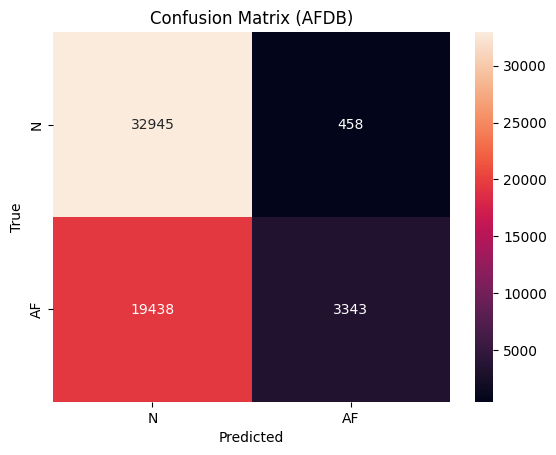

In [9]:
import os
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from ecg_classification.model import ECGCNN
from ecg_classification.config import ECGCNN_CONFIG_L
# from ecg_classification.data import AFDBDualInputDataset  # Make sure this import is correct

# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Load config and model
config = dict(ECGCNN_CONFIG_L)
config["classes"] = 2  # Match what the model was trained on

model = ECGCNN(config).to(device)
model.load_state_dict(torch.load("/content/best_model.pt", map_location=device))
model.eval()

# Load AFDB data
AFDB_PATH = "/content/ECG_Classification/data/mit-bih-atrial-fibrillation-database-1.0.0/files"
record_names = sorted([f.replace(".dat", "") for f in os.listdir(AFDB_PATH) if f.endswith(".dat")])

# Prepare dataset and dataloader
dataset = AFDBDualInputDataset(record_names, afdb_path=AFDB_PATH)
loader = DataLoader(dataset, batch_size=24)

# Inference loop
y_true, y_pred = [], []

with torch.no_grad():
    for ecg_batch, spec_batch, label_batch in loader:
        ecg_batch = ecg_batch.to(device)
        spec_batch = spec_batch.to(device)
        label_batch = label_batch.to(device)

        outputs = model(ecg_batch, spec_batch)
        probs = outputs.softmax(dim=1)
        preds = (probs[:, 1] > 0.5).long()

        y_pred += preds.cpu().tolist()
        y_true += label_batch.cpu().tolist()

# Report
print("\n📊 Classification Report on AFDB (aux_note labels):")
print(classification_report(y_true, y_pred, target_names=["Normal", "AF"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["N", "AF"], yticklabels=["N", "AF"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (AFDB)")
plt.show()


✅ Using device: cuda
Label distribution:
Normal (0): 33403
AFIB   (1): 22781
✅ Loaded 56184 segments from AFDB

📊 Classification Report on AFDB (aux_note labels):
              precision    recall  f1-score   support

      Normal       0.70      0.97      0.81     33403
          AF       0.90      0.40      0.55     22781

    accuracy                           0.74     56184
   macro avg       0.80      0.68      0.68     56184
weighted avg       0.78      0.74      0.71     56184



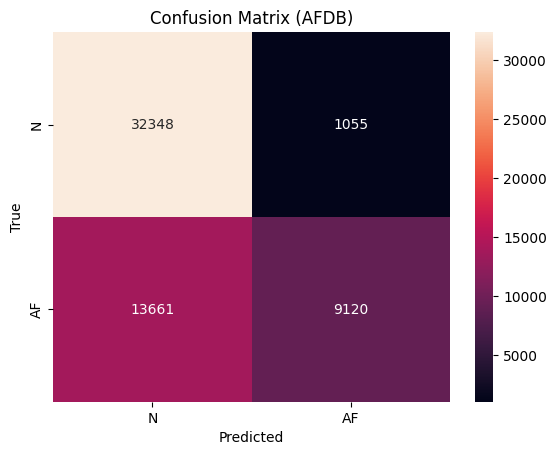

In [10]:
import os
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from ecg_classification.model import ECGCNN
from ecg_classification.config import ECGCNN_CONFIG_L
# from ecg_classification.data import AFDBDualInputDataset  # Make sure this import is correct

# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Load config and model
ECGCNN_SE_CONFIG = dict(ECGCNN_CONFIG_L)
ECGCNN_SE_CONFIG["use_se"] = True
ECGCNN_SE_CONFIG["classes"] = 2  # Match what the model was trained on

model = ECGCNN(config=ECGCNN_SE_CONFIG).to(device)
model.load_state_dict(torch.load("/content/best_model (1).pt", map_location=device))
model.eval()

# Load AFDB data
AFDB_PATH = "/content/ECG_Classification/data/mit-bih-atrial-fibrillation-database-1.0.0/files"
record_names = sorted([f.replace(".dat", "") for f in os.listdir(AFDB_PATH) if f.endswith(".dat")])

# Prepare dataset and dataloader
dataset = AFDBDualInputDataset(record_names, afdb_path=AFDB_PATH)
loader = DataLoader(dataset, batch_size=24)

# Inference loop
y_true, y_pred = [], []

with torch.no_grad():
    for ecg_batch, spec_batch, label_batch in loader:
        ecg_batch = ecg_batch.to(device)
        spec_batch = spec_batch.to(device)
        label_batch = label_batch.to(device)

        outputs = model(ecg_batch, spec_batch)
        probs = outputs.softmax(dim=1)
        preds = (probs[:, 1] > 0.5).long()

        y_pred += preds.cpu().tolist()
        y_true += label_batch.cpu().tolist()

# Report
print("\n📊 Classification Report on AFDB (aux_note labels):")
print(classification_report(y_true, y_pred, target_names=["Normal", "AF"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["N", "AF"], yticklabels=["N", "AF"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (AFDB)")
plt.show()